In [24]:
###### Diabetes type2
#### Date of study : 20190206
import warnings
warnings.filterwarnings("ignore")


In [1]:
# packages
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime 
from sklearn import preprocessing as prep
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Statistics 
from scipy.stats import zscore
from scipy.stats import chi2_contingency
import shap
from sklearn.feature_selection import SelectFromModel


from utils.metrics import evaluate


sns.set(style="white")

from lifelines.plotting import plot_lifetimes

# pandas dislay options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# import data
df=pd.read_csv("datasets/diabetes_dataset.csv",sep="\t")
print("Columns: ",list(df.columns))
print("Data shape: ",df.shape)
df.head()

Columns:  ['ident', 'grossesse', 'allaitementoui', 'ageq3', 'alcool', 'kcalsac', 'aphyq3', 'ATCDfamdiabQ8', 'diab', 'dt_diab', 'encoupleq1', 'etude', 'FDEP99', 'FRAP_I_NC', 'gpsang_rhe', 'hypertensionq3', 'hypolipi2', 'ttailleq4', 'imcq4', 'lateralite', 'statmeno_q3_cl', 'pattern_western', 'pattern_prudent', 'poidsnaiss', 'PRAL', 'ageregle', 'sommeil', 'tabacq3', 'transitq4']
Data shape:  (72890, 29)


,ident,grossesse,allaitementoui,ageq3,alcool,kcalsac,aphyq3,ATCDfamdiabQ8,diab,dt_diab,encoupleq1,etude,FDEP99,FRAP_I_NC,gpsang_rhe,hypertensionq3,hypolipi2,ttailleq4,imcq4,lateralite,statmeno_q3_cl,pattern_western,pattern_prudent,poidsnaiss,PRAL,ageregle,sommeil,tabacq3,transitq4
0,100030,4,0,49.177276,11.88,1488.505569,19.5,0,0,NaN,1,13.0,0.019187,8.455401,4,0,0,79.0,25.64,0,0,-0.528209,-0.642924,3,2.688533,1,2,3,4
1,100035,4,0,44.804928,0.67,2115.009831,4.5,0,0,NaN,1,NaN,0.548716,8.113449,1,0,0,76.0,21.94,0,1,-0.533085,0.047411,1,-4.743413,1,2,3,1
2,100056,4,1,50.907598,3.62,2737.254258,10.5,0,0,NaN,1,13.0,0.236704,10.547431,4,0,0,73.0,21.37,0,0,0.651338,1.198105,1,-8.359993,2,3,3,1
3,100060,4,1,57.297741,0.00,2124.069913,13.5,1,0,NaN,1,13.0,0.455917,13.310274,1,1,0,86.0,29.30,0,1,-0.912994,1.228047,2,18.482343,1,2,3,1
4,100065,4,0,53.021218,21.07,1495.626383,21.0,0,1,01/01/1996,1,13.0,0.561010,13.632363,1,1,0,86.0,31.24,0,1,-0.698218,-0.904501,9,3.074301,1,2,3,1


In [3]:
## According to data description:
#Numerical columns
num_cols = ["ttailleq4","PRAL","ageq3","alcool","aphyq3","FDEP99","FRAP_I_NC","imcq4","kcalsac","pattern_prudent","pattern_western"]
# Categorical columns
cat_cols = ["transitq4","tabacq3","statmeno_q3_cl","allaitementoui","ATCDfamdiabQ8","encoupleq1","gpsang_rhe","grossesse","hypertensionq3","hypolipi2","lateralite"]
# Ordinal columns
ord_cols=["sommeil","ageregle","poidsnaiss","etude"]
# target
target = "diab"  

In [4]:
identifiants = df.ident
dates = df.dt_diab
print("each patient has one and only one diagnosis? :", len(identifiants.unique())==df.shape[0])
# REMOVE IDENT
df.drop(columns=["ident"],axis=1,inplace=True)
# Data description
df.describe()


each patient has one and only one diagnosis? : True


,grossesse,allaitementoui,ageq3,alcool,kcalsac,aphyq3,ATCDfamdiabQ8,diab,encoupleq1,etude,FDEP99,FRAP_I_NC,gpsang_rhe,hypertensionq3,hypolipi2,ttailleq4,imcq4,lateralite,statmeno_q3_cl,pattern_western,pattern_prudent,poidsnaiss,PRAL,ageregle,sommeil,tabacq3,transitq4
count,72890.000000,72890.000000,72890.000000,72890.000000,72890.000000,72371.000000,72890.000000,72890.000000,72890.00000,70405.000000,68691.000000,72890.000000,72890.000000,72890.000000,72890.000000,62680.000000,64208.000000,72890.000000,72890.000000,71450.000000,71450.000000,72890.000000,72890.000000,72890.000000,72890.000000,72890.000000,72890.000000
mean,3.483345,0.618960,52.896163,11.636730,2139.739228,29.480639,0.110632,0.051928,1.13862,14.159520,-0.280755,13.455347,3.476046,0.371985,1.020881,76.049346,23.187644,1.812828,0.903677,0.000988,-0.005883,3.032213,-4.164402,1.686212,3.378666,2.454562,2.542502
std,1.305707,0.485646,6.672942,14.087916,601.607620,35.184340,0.313679,0.221882,1.61034,3.102965,1.041376,5.814052,2.406953,0.483338,2.753328,8.877816,3.382421,3.538736,1.121425,0.998186,0.994773,2.483571,18.031610,1.144519,2.821554,0.930813,2.542565
min,1.000000,0.000000,41.793292,0.000000,11.172228,0.000000,0.000000,0.000000,0.00000,0.000000,-4.114612,0.000000,1.000000,0.000000,0.000000,47.000000,10.950000,0.000000,0.000000,-2.930531,-3.280284,1.000000,-197.350869,1.000000,1.000000,1.000000,1.000000
25%,3.000000,0.000000,47.154004,1.600000,1737.014678,12.000000,0.000000,0.000000,1.00000,13.000000,-0.803137,9.351709,1.000000,0.000000,0.000000,70.000000,20.900000,0.000000,0.000000,-0.709911,-0.696494,2.000000,-14.026541,1.000000,2.000000,2.000000,1.000000
50%,4.000000,1.000000,51.718001,6.870000,2079.203337,21.000000,0.000000,0.000000,1.00000,13.000000,-0.116197,12.568799,4.000000,0.000000,0.000000,75.000000,22.600000,0.000000,1.000000,-0.118908,-0.126775,2.000000,-3.080340,2.000000,2.000000,3.000000,1.000000
75%,4.000000,1.000000,57.675565,16.570000,2470.337099,36.000000,0.000000,0.000000,1.00000,16.000000,0.429316,16.563699,4.000000,1.000000,0.000000,80.000000,24.840000,1.000000,2.000000,0.574606,0.554142,2.000000,7.052055,2.000000,3.000000,3.000000,3.000000
max,9.000000,1.000000,72.019165,304.360000,11110.801314,1200.000000,1.000000,1.000000,9.00000,19.000000,2.674658,103.066004,9.000000,1.000000,9.000000,150.000000,60.970000,9.000000,9.000000,7.778702,9.235585,9.000000,128.219807,9.000000,9.000000,9.000000,9.000000


#### Data cleaning

In [5]:
# Deal with datetime columns 
# Study date: 2019-02-06
df['diagnosis_day'] =(pd.to_datetime("2019-02-06")-pd.to_datetime(df['dt_diab'])).dt.days
df['diagnosis_day'].value_counts()
num_cols = num_cols + ['diagnosis_day'] 

In [6]:
# Deal with NAN values
print('Percentage of nan values %')
nan_data = df[ df.columns[df.isna().any()].tolist()].isna().sum(axis=0)/df.shape[0]*100
print(nan_data)
        

Percentage of nan values %
aphyq3              0.712032
dt_diab            94.807244
etude               3.409247
FDEP99              5.760735
ttailleq4          14.007408
imcq4              11.911099
pattern_western     1.975580
pattern_prudent     1.975580
diagnosis_day      94.807244
dtype: float64


0    69105
1     3785
Name: diab, dtype: int64
3785
target column's minority class (diab=1) represents 5.192756207984634  of data


<Figure size 360x144 with 0 Axes>

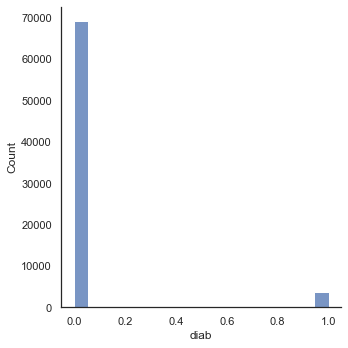

In [7]:
# First analysis: Output distribution
print(df[target].value_counts())
# So dt is only there when target=1 , we will remove it for now with all columns with more than 90% of nan data
print(df["dt_diab"].dropna().shape[0])
data = df.copy()
print("target column's minority class (diab=1) represents",data[target].sum()/data.shape[0]*100," of data")
fig= plt.figure(figsize=(5, 2))
sns.displot(data, x=target)
plt.show()

we have a very unbalanced data so we have to keep that in mind for the training process 

In [8]:
# Deal with NAN values
print('Percentage of nan values %')
nan_data = data[ data.columns[data.isna().any()].tolist()].isna().sum(axis=0)/data.shape[0]*100
print(nan_data)
        

Percentage of nan values %
aphyq3              0.712032
dt_diab            94.807244
etude               3.409247
FDEP99              5.760735
ttailleq4          14.007408
imcq4              11.911099
pattern_western     1.975580
pattern_prudent     1.975580
diagnosis_day      94.807244
dtype: float64


Before dealing with nan values we will conduct an analysis and come back to clean them

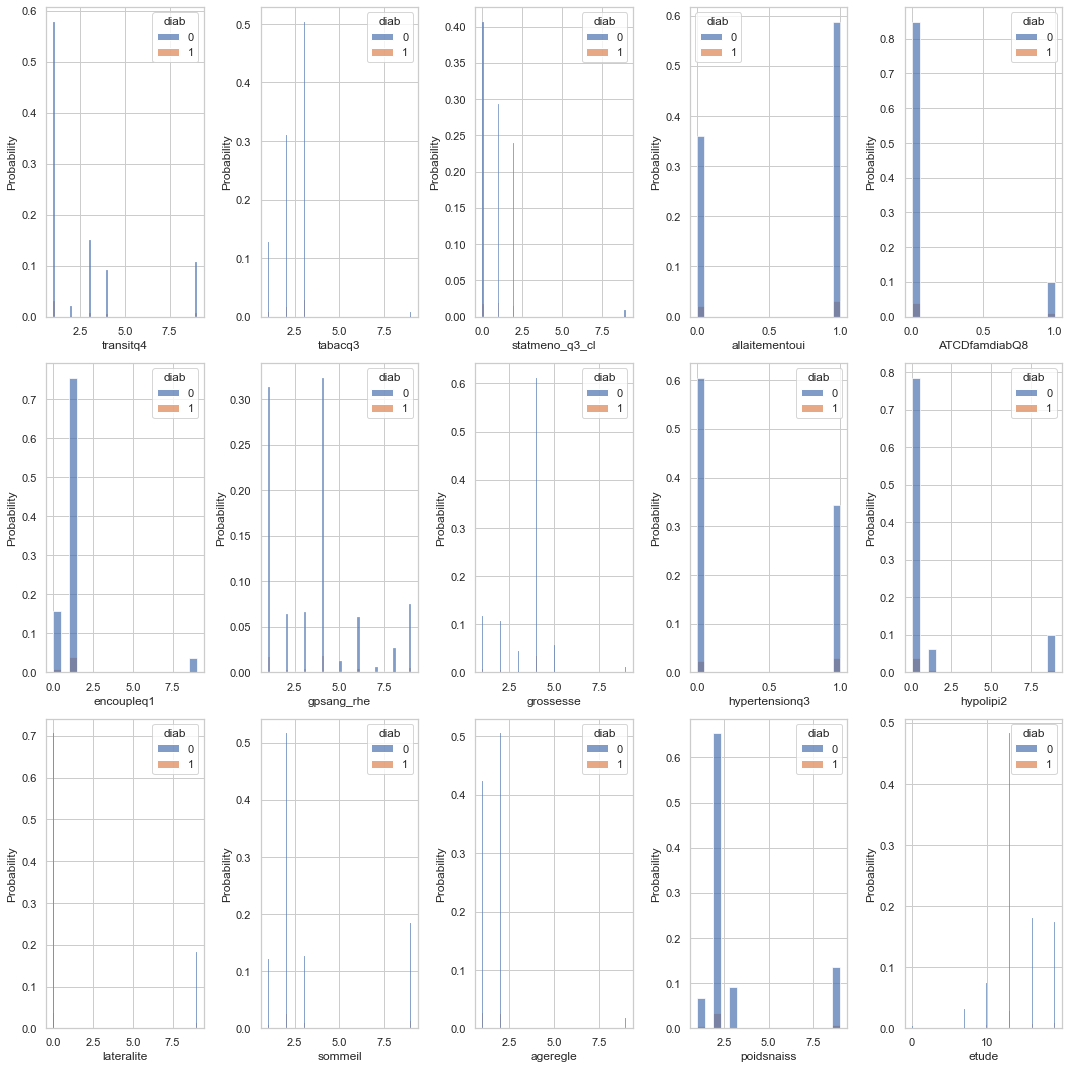

In [10]:
# Categorical columns 
cols = cat_cols+ord_cols
fig, axs = plt.subplots(3, 5,figsize=(15,15))
axes=[]
k=0
for i in range(3):
    for j in range(5):
        g=sns.histplot(data = data,x = cols[k] ,alpha = .7,hue = target,ax=axs[i,j],stat="probability")
        k+=1
fig.tight_layout(pad=1.0) 
plt.savefig("images/cat_target.png")

<ul>Remarks: 
<li> Diabetic people are <b>more likely</b> to have a Family history of diabetes </li>
<li> Treated hypercholesterolaemia have <b>more chances</b> to lead to diabetes</li>
<li>Hypertension can be a <b>cause</b> of diabetes</li>
<li>Weight at birth does not seem to have an impact on diagnosis of diabetes </li>
<li>Early menarche (before 13 yo) have <b>higher risk</b> of type 2 diabetes in adulthood </li>
<li>Higherly educated people have <b>lower risk</b> of type 2 diabetes </li>
</ul>

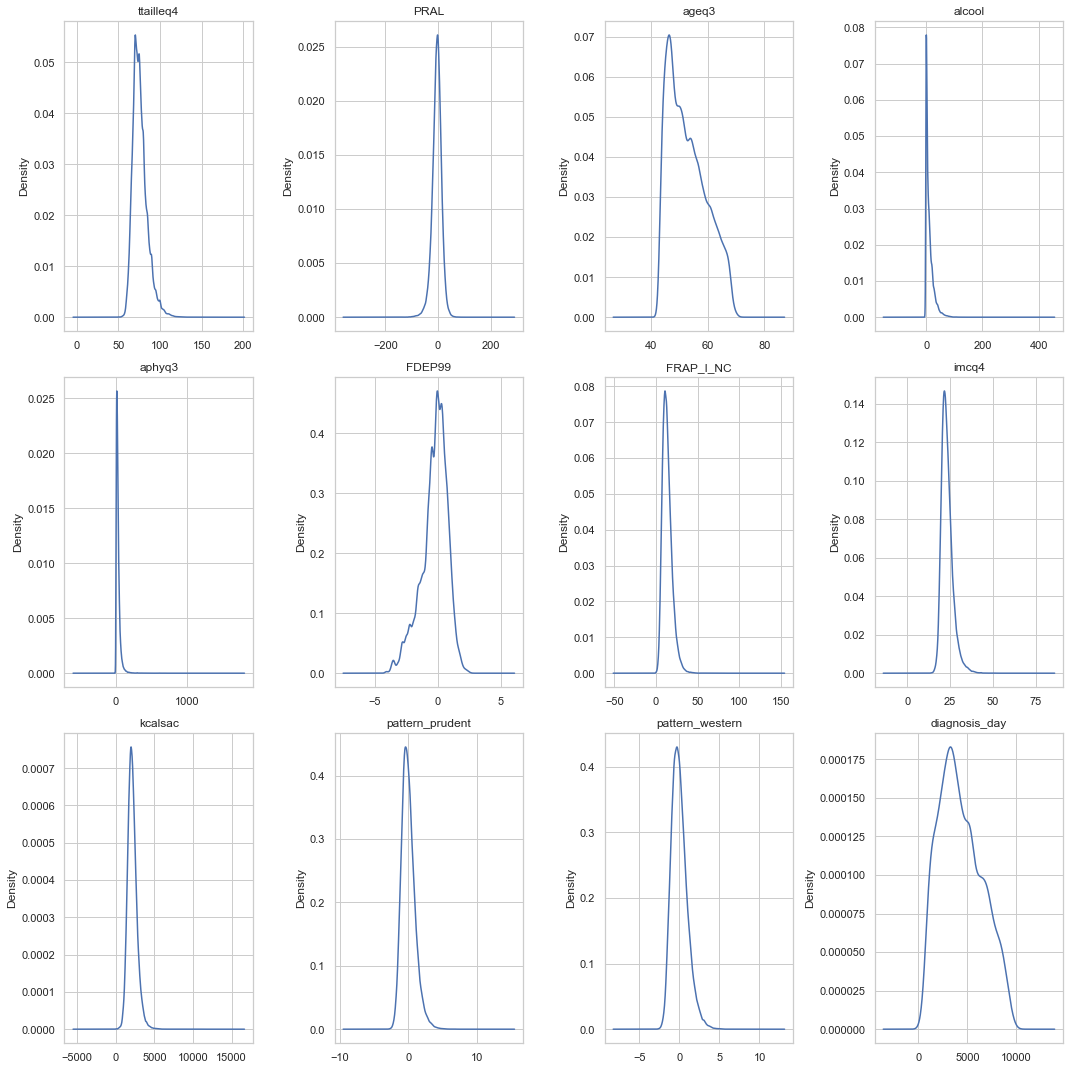

In [135]:
# Numerical features distributions
cols = num_cols
fig, axs = plt.subplots(3, 4,figsize=(15,15))
axes=[]
k=0
for i in range(3):
    for j in range(4):
    
        data[ cols[k]].plot(kind="kde",subplots=True,figsize=(15,10),ax=axs[i,j]) 
        axs[i,j].set_title(cols[k])
            #g=sns.histplot(data = data,x = ,alpha = .7,hue = target,stat="probability")
        k+=1
fig.tight_layout(pad=1.0) 
plt.savefig("images/num_cols.png")



In [140]:
# NUMERICAL FEATURES with trger
swarm_plot = sns.pairplot(data[[target]+num_cols],hue=target)
swarm_plot.savefig("images/num_target.png") 


<ul>Remarks: 
<li> Imc  <b>positively</b> correlated to both diabetes and Waist circumference </li>
<li> Treated hypercholesterolaemia have <b>more chances</b> to lead to diabetes</li>
<li>Energy intake, kcal/day can be impacted Total dietary antioxidant capacity </li>
<li>Active people have higher otal dietary antioxidant capacity </li>

</ul>

======Heatmap=====


[]

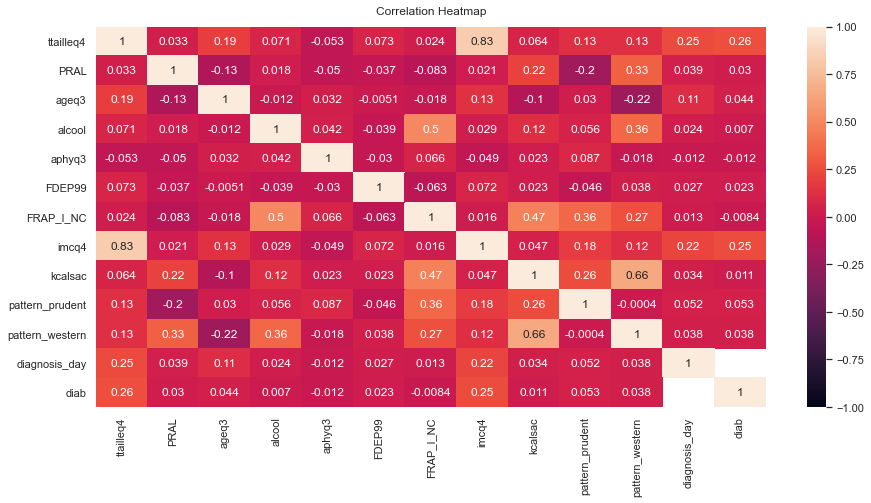

In [9]:
print("======Heatmap=====")
fig = plt.figure(figsize=(15,7))
heatmap = sns.heatmap(data[num_cols+[target]].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.plot()

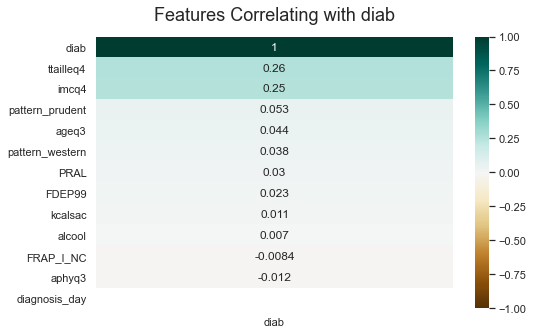

In [10]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(data[num_cols+[target]].corr()[[target]].sort_values(by=target, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target, fontdict={'fontsize':18}, pad=16);


Percentage of outliers in the data per column
ttailleq4          2.867334
PRAL               2.820689
ageq3              0.000000
alcool             5.257237
aphyq3             5.725065
FDEP99             2.933187
FRAP_I_NC          2.398134
imcq4              2.890657
kcalsac            2.229387
pattern_prudent    2.081218
pattern_western    1.819180
diagnosis_day      0.000000
dtype: float64


Text(0.5, 1.0, 'Outliers in numerical data')

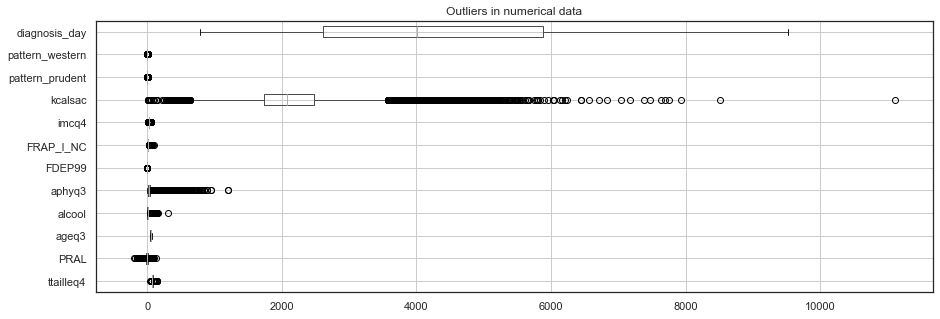

In [11]:
# Let's handle outliers 

# Calculate quantiles 25% and 75%
Q1 = data[num_cols].quantile(0.25)
Q3 = data[num_cols].quantile(0.75)
IQR = Q3 - Q1 # Interquantile
print("Percentage of outliers in the data per column")
print(((data[num_cols] < (Q1 - 1.5 * IQR)) | (data[num_cols] > (Q3 + 1.5 * IQR))).sum()/data[num_cols].shape[0]*100
)

figure=plt.figure(figsize=(15,5))
data[num_cols].boxplot(vert=False)
plt.title("Outliers in numerical data")

Some of features has more than 4% of the data as outliers namely alcool ) which has only few values as more than one so we will keep them for now

In [12]:
# Select categorical columns 
df_c = data[cat_cols+[target]]
chi2_check = []
for i in cat_cols: #categorical columns
    if chi2_contingency(pd.crosstab(df_c[target], df_c[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [cat_cols, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
print(res)

            Column                      Hypothesis
0        transitq4          Reject Null Hypothesis
1          tabacq3          Reject Null Hypothesis
2   statmeno_q3_cl          Reject Null Hypothesis
3   allaitementoui          Reject Null Hypothesis
4    ATCDfamdiabQ8          Reject Null Hypothesis
5       encoupleq1          Reject Null Hypothesis
6       gpsang_rhe          Reject Null Hypothesis
7        grossesse  Fail to Reject Null Hypothesis
8   hypertensionq3          Reject Null Hypothesis
9        hypolipi2          Reject Null Hypothesis
10      lateralite          Reject Null Hypothesis


## Features engineering

In [13]:
# Deal with NAN values
print('Percentage of nan values %')
nan_data = df[ df.columns[df.isna().any()].tolist()].isna().sum(axis=0)/df.shape[0]*100
print(nan_data)


Percentage of nan values %
aphyq3              0.712032
dt_diab            94.807244
etude               3.409247
FDEP99              5.760735
ttailleq4          14.007408
imcq4              11.911099
pattern_western     1.975580
pattern_prudent     1.975580
diagnosis_day      94.807244
dtype: float64


### Studies

In [14]:
data_test= data.copy()
data_test[["etude",target]].corr()

,etude,diab
etude,1.00000,-0.04041
diab,-0.04041,1.00000


<AxesSubplot:xlabel='etude', ylabel='Probability'>

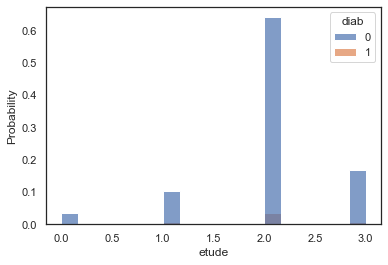

In [15]:
def organise_etude(x):
    if x<13 and x!=0: # less than High school level
        return 1 
    elif x==0: #iletrate 
        return 0
    elif x>=13 and x<=16: # Masters
        return 2
    elif x<=19: #PHD
        return 3
    else: # Consier none as no education
        return 0
data_test["etude"]= data_test["etude"].apply(organise_etude)
data_test[["etude",target]].corr()
sns.histplot(data = data_test,x = "etude" ,alpha = .7,hue = target,stat="probability")


### Waist circumference and IMC

In [16]:
# Deal with NAN values
print('Percentage of nan values %')
nan_data = data_test[ data_test.columns[df.isna().any()].tolist()].isna().sum(axis=0)/data_test.shape[0]*100
print(nan_data)


Percentage of nan values %
aphyq3              0.712032
dt_diab            94.807244
etude               0.000000
FDEP99              5.760735
ttailleq4          14.007408
imcq4              11.911099
pattern_western     1.975580
pattern_prudent     1.975580
diagnosis_day      94.807244
dtype: float64


In [17]:
# Since mcq3 is highrly correlated to taille let's categorize this one replace values with 0.5 imp
data_test[["imcq4",'ttailleq4']].corr()
data_test.ttailleq4.fillna(df.imcq4*100/83, inplace=True)
data_test.imcq4.fillna(df.ttailleq4*0.83, inplace=True)

In [18]:
data = data_test.copy()

In [19]:
# Encode cat colus
print(data[cat_cols].nunique())
for col in cat_cols:
    if len(data[col].unique())>=3:
        dummies=pd.get_dummies(data[col],prefix=col)
        data_encoded=pd.concat([data,dummies],axis=1)
        data_encoded.drop(columns=col,inplace=True)

transitq4         5
tabacq3           4
statmeno_q3_cl    4
allaitementoui    2
ATCDfamdiabQ8     2
encoupleq1        3
gpsang_rhe        9
grossesse         6
hypertensionq3    2
hypolipi2         3
lateralite        3
dtype: int64


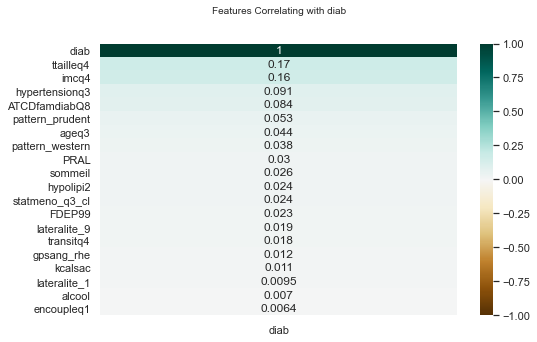

In [20]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(data_encoded.corr()[[target]].sort_values(by=target, ascending=False)[:20], vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target, fontdict={'fontsize':10}, pad=30);


### Split train/test

In [131]:
## Define test train sets with target 
#X_train, X_test, y_train, y_test = train_test_split(data_encoded.drop(columns=[target,"diagnosis_day","dt_diab","imcq4"]), data_encoded[target], test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[target,"diagnosis_day","dt_diab","imcq4"]), data[target], test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

print('training:')
print(y_train.value_counts())
print('testing:')
print(y_test.value_counts())

training:
0    49757
1     2723
Name: diab, dtype: int64
testing:
0    13838
1      740
Name: diab, dtype: int64


In [132]:
### Deal wit nan values
# Fill in nan values with median 
medians = X_train.median()

X_train=X_train.fillna(medians)
# Apply it on Test 
X_test=X_test.fillna(medians)

In [24]:
# SelectFromModel will select those features which importance is greater than the mean importance of all the features by default, but we can alter this threshold if we want.
sel = SelectFromModel(RandomForestClassifier(n_estimators = 200))
sel.fit(X_train,y_train)
selected_feat= X_train.columns[(sel.get_support())]



In [25]:
# C heck and plot the distribution of importance
selected_feat

Index(['ageq3', 'alcool', 'kcalsac', 'aphyq3', 'FDEP99', 'FRAP_I_NC', 'ttailleq4', 'pattern_western', 'pattern_prudent', 'PRAL'], dtype='object')

In [26]:
# Select only features above
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

## UndersamPling major class

In [133]:
#============First strategy: random undersampLing=================================================================================#
# Create an undersampler object
rus = RandomUnderSampler(0.5)
X_train_us, y_train_us= rus.fit_resample(X_train, y_train)

#============2nd strategy: Synthetic oversampling=================================================================================
### oversample :
sm = SMOTE(0.2)
#X_train_us, y_train_us=sm.fit_resample(X_train, y_train)
y_train_us.value_counts()


#============3rd strategy: outliers removal =================================================================================
### oversample :
train=pd.concat([X_train,y_train],axis=1)
df_outliers = train.apply(zscore).apply(lambda x: x > 3).sum(axis=1)+train.apply(zscore).apply(lambda x: x<-3).sum(axis=1)
df_outliers=pd.concat([df_outliers.to_frame().rename(columns={0:"outliers_count"}),y_train],axis=1)
index_outliers = list(df_outliers[(df_outliers.outliers_count>0) & (df_outliers.diab==0)].index)
#X_train_us = X_train.drop(index=index_outliers)
#y_train_us = y_train.drop(index=index_outliers)
#X_train_us, y_train_us= rus.fit_resample(X_train_us, y_train_us)
#X_train_us = X_train
#y_train_us = y_train
print("After random undersampling\n",y_train_us.value_counts())

After random undersampling
 0    5446
1    2723
Name: diab, dtype: int64


In [42]:
# REG
scaler= prep.StandardScaler()
# Fit on train and apply it
X_train_sc = scaler.fit_transform(X_train_us,y_train_us)
y_train_sc=y_train_us
# Apply on test 
X_test_sc = scaler.fit_transform(X_test)

In [43]:
# First baseline model 
LR = LogisticRegression( penalty='l2',solver="liblinear")
LR.fit(X_train_sc,y_train_sc)
# Predict 
predictions = LR.predict(X_test)
# Use score method to get accuracy of model
score = LR.score(X_test_sc, y_test)
print("Model's accuracy :",score)
cm = metrics.confusion_matrix(y_test, predictions)
print(metrics.classification_report(y_test, predictions))

Model's accuracy : 0.817327479764028
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13838
           1       0.11      0.00      0.01       740

    accuracy                           0.95     14578
   macro avg       0.53      0.50      0.49     14578
weighted avg       0.91      0.95      0.92     14578



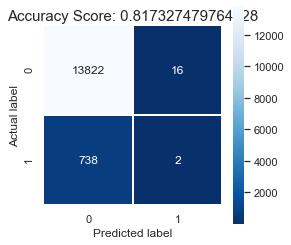

In [44]:
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

==========CONFUSION MATRIX==========


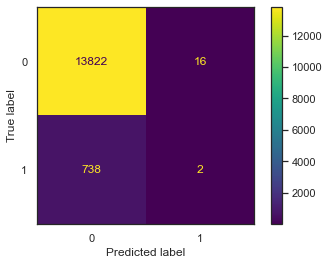

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13838
           1       0.11      0.00      0.01       740

    accuracy                           0.95     14578
   macro avg       0.53      0.50      0.49     14578
weighted avg       0.91      0.95      0.92     14578

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.5286117740807725


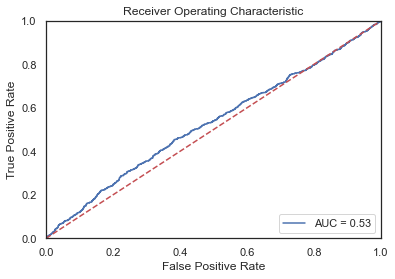

==========PR CURVE==========
Logistic: f1=0.005 auc=0.057


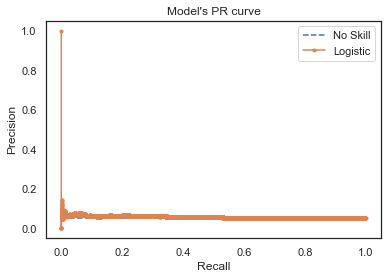

In [45]:
evaluate(LR ,X_test,y_test)

# Ensemble methods:
      ## Bagging: Random forest
      ## Bosting: XGBOOST
    

In [46]:
RF = RandomForestClassifier(class_weight='balanced')
RF.fit(X_train_us,y_train_us)
# Predict 
predictions = RF.predict(X_test)
# Use score method to get accuracy of model
score = RF.score(X_test, y_test)
print("Model's accuracy :",score)


Model's accuracy : 0.871518726848676


==========CONFUSION MATRIX==========


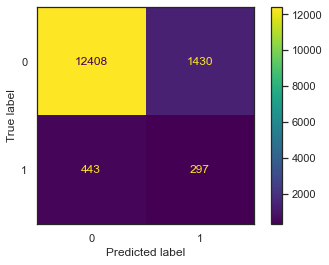

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     13838
           1       0.17      0.40      0.24       740

    accuracy                           0.87     14578
   macro avg       0.57      0.65      0.59     14578
weighted avg       0.93      0.87      0.89     14578

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.7640256168873021


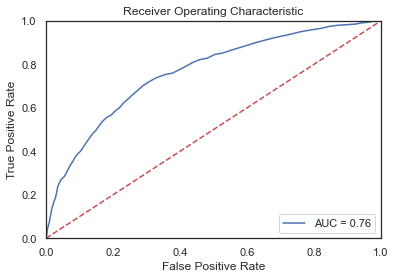

==========PR CURVE==========
Logistic: f1=0.241 auc=0.174


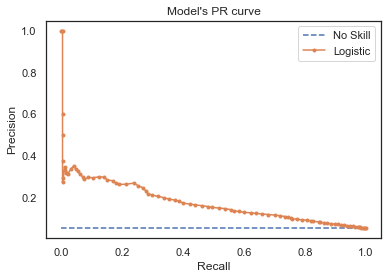

In [47]:
evaluate(RF ,X_test,y_test)

In [48]:
XG = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',scale_pos_weight=2)
XG.fit(X_train_us,y_train_us)
# Predict 
predictions = XG.predict(X_test)
# Use score method to getN accuracy of model
score = XG.score(X_test, y_test)
print("Model's accuracy :",score)


Model's accuracy : 0.7612841267663603


==========CONFUSION MATRIX==========


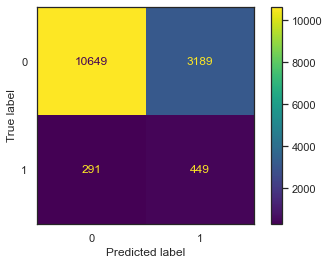

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     13838
           1       0.12      0.61      0.21       740

    accuracy                           0.76     14578
   macro avg       0.55      0.69      0.53     14578
weighted avg       0.93      0.76      0.83     14578

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.7544420377886196


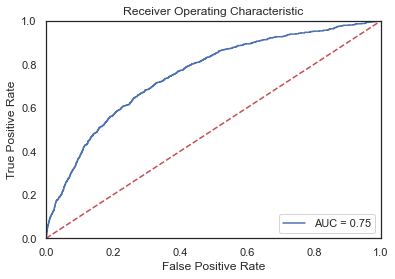

==========PR CURVE==========
Logistic: f1=0.205 auc=0.160


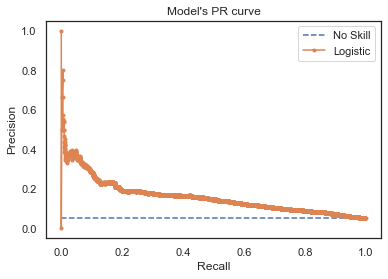

In [49]:
evaluate(XG ,X_test,y_test)

In [137]:
X_train_us

,grossesse,allaitementoui,ageq3,alcool,kcalsac,aphyq3,ATCDfamdiabQ8,encoupleq1,etude,FDEP99,FRAP_I_NC,gpsang_rhe,hypertensionq3,hypolipi2,ttailleq4,lateralite,statmeno_q3_cl,pattern_western,pattern_prudent,poidsnaiss,PRAL,ageregle,sommeil,tabacq3,transitq4
0,1,0,63.863107,0.00,1932.897307,67.50,0,0,2,-0.224976,17.495579,1,1,0,71.0,0,2,-1.058306,-0.691104,2,-21.809657,2,2,2,3
1,4,1,56.887064,14.83,2117.579289,21.00,0,0,3,-0.116197,8.478280,1,1,0,85.0,1,2,0.480944,-0.765188,2,17.730036,2,2,2,1
2,1,0,49.023956,1.17,2079.940119,9.75,0,1,2,0.582868,10.800268,6,0,0,89.0,0,1,-0.834651,0.671963,2,-3.924785,2,1,2,3
3,1,0,46.924025,1.64,1977.272368,36.00,0,1,2,0.590369,12.946380,4,0,0,67.0,0,0,0.056444,0.744475,2,-37.649872,1,2,2,1
4,4,1,45.420945,0.72,2142.822243,69.00,1,1,1,0.756362,7.348172,4,0,0,77.0,0,0,-0.237016,0.070698,2,-2.782748,2,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,4,0,49.735797,0.00,1334.746661,15.00,0,1,2,-2.898051,8.645729,9,0,9,74.0,9,0,-1.041816,1.314260,9,5.363294,1,9,1,9
8165,4,0,47.101985,15.41,2185.784875,21.00,0,0,2,-1.428567,21.426054,1,1,0,70.0,0,0,0.101459,1.548465,2,-30.034235,2,1,1,4
8166,1,0,43.942505,7.78,2317.612207,16.50,0,1,2,-0.534245,27.264329,4,1,1,79.0,9,0,-0.673878,1.318745,2,-3.642875,1,9,3,2
8167,5,1,58.647502,0.97,1330.027927,21.00,0,1,2,-0.116197,8.619942,4,1,0,97.0,0,1,-1.100886,0.141140,2,-7.168263,2,3,3,1


# Catboost

In [147]:
from catboost import CatBoostClassifier
selected=['ageq3',
 'alcool',
 'kcalsac',
 'aphyq3',
 'ATCDfamdiabQ8',
 'FDEP99',
 'FRAP_I_NC',
 'hypolipi2',
 'ttailleq4',
 'pattern_western',
 'pattern_prudent',
 'PRAL']
clf = CatBoostClassifier(iterations=200, learning_rate=0.1, custom_loss='AUC',scale_pos_weight=2)
#loss_function='CrossEntropy')
#clf.fit(X_train_us[selected], y_train_us, cat_features=cat_cols+['etude']+ord_cols,eval_set=(X_val[selected], y_val), verbose=True)
clf.fit(X_train_us[selected], y_train_us, cat_features=['ATCDfamdiabQ8','hypolipi2'],eval_set=(X_val[selected], y_val), verbose=True)

clf.fit(X_train_us[selected],y_train_us)
# Predict 
predictions = clf.predict(X_test[selected])
# Use score method to getN accuracy of model
score = clf.score(X_test[selected], y_test)
print("Model's accuracy :",score)


0:	learn: 0.6738465	test: 0.6763214	best: 0.6763214 (0)	total: 48.8ms	remaining: 9.72s
1:	learn: 0.6588355	test: 0.6617094	best: 0.6617094 (1)	total: 71.9ms	remaining: 7.12s
2:	learn: 0.6465210	test: 0.6532724	best: 0.6532724 (2)	total: 114ms	remaining: 7.5s
3:	learn: 0.6359897	test: 0.6391859	best: 0.6391859 (3)	total: 139ms	remaining: 6.81s
4:	learn: 0.6245206	test: 0.6303559	best: 0.6303559 (4)	total: 163ms	remaining: 6.34s
5:	learn: 0.6169226	test: 0.6238378	best: 0.6238378 (5)	total: 197ms	remaining: 6.38s
6:	learn: 0.6098027	test: 0.6168057	best: 0.6168057 (6)	total: 222ms	remaining: 6.13s
7:	learn: 0.6037904	test: 0.6110641	best: 0.6110641 (7)	total: 247ms	remaining: 5.92s
8:	learn: 0.5988679	test: 0.5993844	best: 0.5993844 (8)	total: 275ms	remaining: 5.83s
9:	learn: 0.5950648	test: 0.5990329	best: 0.5990329 (9)	total: 301ms	remaining: 5.72s
10:	learn: 0.5917470	test: 0.5958219	best: 0.5958219 (10)	total: 325ms	remaining: 5.58s
11:	learn: 0.5881787	test: 0.5926320	best: 0.592632

98:	learn: 0.5094997	test: 0.5180335	best: 0.5180335 (98)	total: 2.76s	remaining: 2.81s
99:	learn: 0.5088650	test: 0.5177645	best: 0.5177645 (99)	total: 2.78s	remaining: 2.78s
100:	learn: 0.5079498	test: 0.5176739	best: 0.5176739 (100)	total: 2.81s	remaining: 2.75s
101:	learn: 0.5071596	test: 0.5176221	best: 0.5176221 (101)	total: 2.84s	remaining: 2.73s
102:	learn: 0.5066628	test: 0.5158379	best: 0.5158379 (102)	total: 2.88s	remaining: 2.71s
103:	learn: 0.5060828	test: 0.5155064	best: 0.5155064 (103)	total: 2.9s	remaining: 2.68s
104:	learn: 0.5054164	test: 0.5154205	best: 0.5154205 (104)	total: 2.96s	remaining: 2.67s
105:	learn: 0.5044489	test: 0.5152298	best: 0.5152298 (105)	total: 2.99s	remaining: 2.65s
106:	learn: 0.5035771	test: 0.5151532	best: 0.5151532 (106)	total: 3.01s	remaining: 2.62s
107:	learn: 0.5026904	test: 0.5146479	best: 0.5146479 (107)	total: 3.06s	remaining: 2.6s
108:	learn: 0.5020264	test: 0.5139962	best: 0.5139962 (108)	total: 3.11s	remaining: 2.6s
109:	learn: 0.501

197:	learn: 0.4459241	test: 0.4979490	best: 0.4979490 (197)	total: 6.43s	remaining: 64.9ms
198:	learn: 0.4453917	test: 0.4979503	best: 0.4979490 (197)	total: 6.46s	remaining: 32.4ms
199:	learn: 0.4445896	test: 0.4975924	best: 0.4975924 (199)	total: 6.48s	remaining: 0us

bestTest = 0.4975923732
bestIteration = 199

0:	learn: 0.6773310	total: 21.5ms	remaining: 4.28s
1:	learn: 0.6632560	total: 31.3ms	remaining: 3.1s
2:	learn: 0.6497325	total: 38.3ms	remaining: 2.51s
3:	learn: 0.6353162	total: 43.8ms	remaining: 2.15s
4:	learn: 0.6259049	total: 47.8ms	remaining: 1.86s
5:	learn: 0.6167429	total: 52.2ms	remaining: 1.69s
6:	learn: 0.6109534	total: 56.8ms	remaining: 1.56s
7:	learn: 0.6053848	total: 61.2ms	remaining: 1.47s
8:	learn: 0.6008717	total: 65.3ms	remaining: 1.39s
9:	learn: 0.5963722	total: 70ms	remaining: 1.33s
10:	learn: 0.5925453	total: 74.3ms	remaining: 1.28s
11:	learn: 0.5890151	total: 78.7ms	remaining: 1.23s
12:	learn: 0.5856322	total: 83.1ms	remaining: 1.2s
13:	learn: 0.5823559	t

176:	learn: 0.4537935	total: 796ms	remaining: 103ms
177:	learn: 0.4531216	total: 801ms	remaining: 99ms
178:	learn: 0.4527744	total: 805ms	remaining: 94.5ms
179:	learn: 0.4522082	total: 810ms	remaining: 90ms
180:	learn: 0.4514886	total: 816ms	remaining: 85.7ms
181:	learn: 0.4506775	total: 821ms	remaining: 81.2ms
182:	learn: 0.4501343	total: 825ms	remaining: 76.6ms
183:	learn: 0.4493173	total: 830ms	remaining: 72.1ms
184:	learn: 0.4485358	total: 834ms	remaining: 67.6ms
185:	learn: 0.4479647	total: 838ms	remaining: 63.1ms
186:	learn: 0.4473956	total: 843ms	remaining: 58.6ms
187:	learn: 0.4469936	total: 847ms	remaining: 54.1ms
188:	learn: 0.4464769	total: 851ms	remaining: 49.5ms
189:	learn: 0.4457866	total: 855ms	remaining: 45ms
190:	learn: 0.4452909	total: 860ms	remaining: 40.5ms
191:	learn: 0.4447316	total: 864ms	remaining: 36ms
192:	learn: 0.4443470	total: 868ms	remaining: 31.5ms
193:	learn: 0.4436874	total: 872ms	remaining: 27ms
194:	learn: 0.4433057	total: 876ms	remaining: 22.5ms
195:

==========CONFUSION MATRIX==========


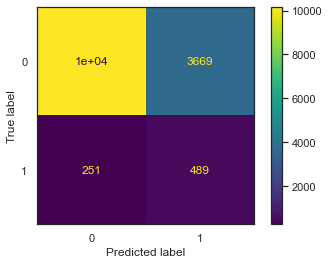

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     13838
           1       0.12      0.66      0.20       740

    accuracy                           0.73     14578
   macro avg       0.55      0.70      0.52     14578
weighted avg       0.93      0.73      0.81     14578

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.7700880458432129


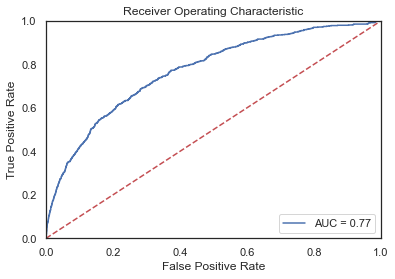

==========PR CURVE==========
Logistic: f1=0.200 auc=0.200


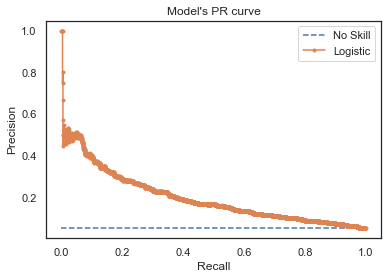

In [148]:
evaluate(clf ,X_test[selected],y_test)

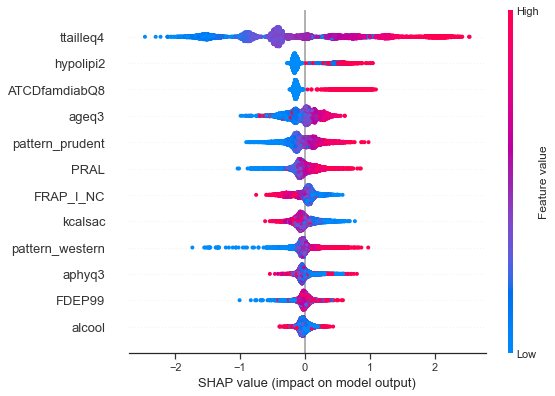

In [149]:
# Features importance :
pred = clf.predict(X_train_us[selected])
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_us[selected])
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()
shap.summary_plot(shap_values, X_train_us[selected])


# Risk and survival analysis

In [150]:
data['diagnosis_day'].describe()

count    3785.000000
mean     4322.902774
std      2151.935929
min       784.000000
25%      2612.000000
50%      4010.000000
75%      5880.000000
max      9524.000000
Name: diagnosis_day, dtype: float64

##### <div class="section" id="survival-function">
<h2>Survival function<a class="headerlink" href="#survival-function" title="Permalink to this headline">¶</a></h2>
<p>Let <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-7-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>T</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-23" style="width: 0.857em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.697em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.392em, 1000.7em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-24"><span class="mi" id="MathJax-Span-25" style="font-family: MathJax_Math-italic;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 0.941em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>T</mi></math></span></span><script type="math/tex" id="MathJax-Element-7">T</script></span> be a (possibly infinite, but always non-negative) random
lifetime taken from the population under study. For example, the
amount of time a couple is married <b>(In case of diabetes we will age)</b>. Or the time it takes a user to enter
a webpage (an infinite time if they never do). The survival function -
<span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-8-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-26" style="width: 2.139em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.819em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1001.71em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-27"><span class="mi" id="MathJax-Span-28" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-29" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-30" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-31" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-8">S(t)</script></span> - of a population is defined as</p>
<div class="math notranslate nohighlight">
<span class="MathJax_Preview" style="color: inherit;"></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-9-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><mi>P</mi><mi>r</mi><mo stretchy=&quot;false&quot;>(</mo><mi>T</mi><mo>&amp;gt;</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-32" style="width: 8.763em; display: inline-block;"><span style="display: inline-block; position: relative; width: 7.481em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1007.37em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-33"><span class="mi" id="MathJax-Span-34" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-35" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-36" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-37" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-38" style="font-family: MathJax_Main; padding-left: 0.27em;">=</span><span class="mi" id="MathJax-Span-39" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">P<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span class="mi" id="MathJax-Span-40" style="font-family: MathJax_Math-italic;">r</span><span class="mo" id="MathJax-Span-41" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-42" style="font-family: MathJax_Math-italic;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span class="mo" id="MathJax-Span-43" style="font-family: MathJax_Main; padding-left: 0.27em;">&gt;</span><span class="mi" id="MathJax-Span-44" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">t</span><span class="mo" id="MathJax-Span-45" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><mi>P</mi><mi>r</mi><mo stretchy="false">(</mo><mi>T</mi><mo>&gt;</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-9">S(t) = Pr(T > t)</script></div>
<p>Simply, the survival function defines the probability the death event has not occurred yet at time
<span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-10-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-46" style="width: 0.43em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.377em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.445em, 1000.32em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-47"><span class="mi" id="MathJax-Span-48" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 0.878em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-10">t</script></span>, or equivalently, the probability of surviving past time
<span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-11-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-49" style="width: 0.43em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.377em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.445em, 1000.32em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-50"><span class="mi" id="MathJax-Span-51" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 0.878em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-11">t</script></span>. Note the following properties of the survival function:</p>
<ol class="arabic simple">
<li><span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-12-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mn>0</mn><mo>&amp;#x2264;</mo><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>&amp;#x2264;</mo><mn>1</mn></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-52" style="width: 6.413em; display: inline-block;"><span style="display: inline-block; position: relative; width: 5.451em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1005.4em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-53"><span class="mn" id="MathJax-Span-54" style="font-family: MathJax_Main;">0</span><span class="mo" id="MathJax-Span-55" style="font-family: MathJax_Main; padding-left: 0.27em;">≤</span><span class="mi" id="MathJax-Span-56" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-57" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-58" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-59" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-60" style="font-family: MathJax_Main; padding-left: 0.27em;">≤</span><span class="mn" id="MathJax-Span-61" style="font-family: MathJax_Main; padding-left: 0.27em;">1</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mn>0</mn><mo>≤</mo><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>≤</mo><mn>1</mn></math></span></span><script type="math/tex" id="MathJax-Element-12">0 \le S(t) \le 1</script></span></li>
<li><span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-13-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>F</mi><mi>T</mi></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><mn>1</mn><mo>&amp;#x2212;</mo><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-62" style="width: 8.443em; display: inline-block;"><span style="display: inline-block; position: relative; width: 7.214em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1007.11em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-63"><span class="msubsup" id="MathJax-Span-64"><span style="display: inline-block; position: relative; width: 1.231em; height: 0px;"><span style="position: absolute; clip: rect(3.154em, 1000.75em, 4.169em, -999.997em); top: -4.004em; left: 0em;"><span class="mi" id="MathJax-Span-65" style="font-family: MathJax_Math-italic;">F<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; top: -3.843em; left: 0.644em;"><span class="mi" id="MathJax-Span-66" style="font-size: 70.7%; font-family: MathJax_Math-italic;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="mo" id="MathJax-Span-67" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-68" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-69" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-70" style="font-family: MathJax_Main; padding-left: 0.27em;">=</span><span class="mn" id="MathJax-Span-71" style="font-family: MathJax_Main; padding-left: 0.27em;">1</span><span class="mo" id="MathJax-Span-72" style="font-family: MathJax_Main; padding-left: 0.216em;">−</span><span class="mi" id="MathJax-Span-73" style="font-family: MathJax_Math-italic; padding-left: 0.216em;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-74" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-75" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-76" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>F</mi><mi>T</mi></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><mn>1</mn><mo>−</mo><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-13">F_T(t) = 1 - S(t)</script></span>, where <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-14-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>F</mi><mi>T</mi></msub><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-77" style="width: 2.834em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.407em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1002.3em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-78"><span class="msubsup" id="MathJax-Span-79"><span style="display: inline-block; position: relative; width: 1.231em; height: 0px;"><span style="position: absolute; clip: rect(3.154em, 1000.75em, 4.169em, -999.997em); top: -4.004em; left: 0em;"><span class="mi" id="MathJax-Span-80" style="font-family: MathJax_Math-italic;">F<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; top: -3.843em; left: 0.644em;"><span class="mi" id="MathJax-Span-81" style="font-size: 70.7%; font-family: MathJax_Math-italic;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="mo" id="MathJax-Span-82" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-83" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-84" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>F</mi><mi>T</mi></msub><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-14">F_T(t)</script></span> is the CDF of <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-15-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>T</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-85" style="width: 0.857em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.697em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.392em, 1000.7em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-86"><span class="mi" id="MathJax-Span-87" style="font-family: MathJax_Math-italic;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 0.941em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>T</mi></math></span></span><script type="math/tex" id="MathJax-Element-15">T</script></span>, which implies</li>
<li><span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-16-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-88" style="width: 2.139em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.819em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1001.71em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-89"><span class="mi" id="MathJax-Span-90" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-91" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-92" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-93" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-16">S(t)</script></span> is a non-increasing function of <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-17-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-94" style="width: 0.43em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.377em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.445em, 1000.32em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-95"><span class="mi" id="MathJax-Span-96" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 0.878em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-17">t</script></span>.</li>
</ol>
</div>

<div class="section" id="hazard-function">
<h2>Hazard function<a class="headerlink" href="#hazard-function" title="Permalink to this headline">¶</a></h2>
<p>We are also interested in the probability of the death event occurring at time <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-18-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-97" style="width: 0.43em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.377em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.445em, 1000.32em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-98"><span class="mi" id="MathJax-Span-99" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 0.878em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-18">t</script></span>,
given that the death event has not occurred yet. Mathematically, that is:</p>
<div class="math notranslate nohighlight">
<span class="MathJax_Preview" style="color: inherit;"></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-19-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><munder><mo movablelimits=&quot;true&quot; form=&quot;prefix&quot;>lim</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>&amp;#x03B4;</mi><mi>t</mi><mo stretchy=&quot;false&quot;>&amp;#x2192;</mo><mn>0</mn></mrow></munder><mspace width=&quot;thickmathspace&quot; /><mi>P</mi><mi>r</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>&amp;#x2264;</mo><mi>T</mi><mo>&amp;#x2264;</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mi>t</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo stretchy=&quot;false&quot;>|</mo></mrow><mi>T</mi><mo>&amp;gt;</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-100" style="width: 14.96em; display: inline-block;"><span style="display: inline-block; position: relative; width: 12.77em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1012.66em, 3.208em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-101"><span class="munderover" id="MathJax-Span-102"><span style="display: inline-block; position: relative; width: 1.659em; height: 0px;"><span style="position: absolute; clip: rect(3.154em, 1001.39em, 4.169em, -999.997em); top: -4.004em; left: 0.11em;"><span class="mo" id="MathJax-Span-103" style="font-family: MathJax_Main;">lim</span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(3.368em, 1001.61em, 4.276em, -999.997em); top: -3.309em; left: 0em;"><span class="texatom" id="MathJax-Span-104"><span class="mrow" id="MathJax-Span-105"><span class="mi" id="MathJax-Span-106" style="font-size: 70.7%; font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-107" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-108" style="font-size: 70.7%; font-family: MathJax_Main;">→</span><span class="mn" id="MathJax-Span-109" style="font-size: 70.7%; font-family: MathJax_Main;">0</span></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="mspace" id="MathJax-Span-110" style="height: 0em; vertical-align: 0em; width: 0.27em; display: inline-block; overflow: hidden;"></span><span class="mi" id="MathJax-Span-111" style="font-family: MathJax_Math-italic; padding-left: 0.163em;">P<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span class="mi" id="MathJax-Span-112" style="font-family: MathJax_Math-italic;">r</span><span class="mo" id="MathJax-Span-113" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-114" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-115" style="font-family: MathJax_Main; padding-left: 0.27em;">≤</span><span class="mi" id="MathJax-Span-116" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span class="mo" id="MathJax-Span-117" style="font-family: MathJax_Main; padding-left: 0.27em;">≤</span><span class="mi" id="MathJax-Span-118" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">t</span><span class="mo" id="MathJax-Span-119" style="font-family: MathJax_Main; padding-left: 0.216em;">+</span><span class="mi" id="MathJax-Span-120" style="font-family: MathJax_Math-italic; padding-left: 0.216em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-121" style="font-family: MathJax_Math-italic;">t</span><span class="texatom" id="MathJax-Span-122"><span class="mrow" id="MathJax-Span-123"><span class="mo" id="MathJax-Span-124" style="font-family: MathJax_Main;">|</span></span></span><span class="mi" id="MathJax-Span-125" style="font-family: MathJax_Math-italic;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span class="mo" id="MathJax-Span-126" style="font-family: MathJax_Main; padding-left: 0.27em;">&gt;</span><span class="mi" id="MathJax-Span-127" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">t</span><span class="mo" id="MathJax-Span-128" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.997em; border-left: 0px solid; width: 0px; height: 1.941em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><munder><mo movablelimits="true" form="prefix">lim</mo><mrow class="MJX-TeXAtom-ORD"><mi>δ</mi><mi>t</mi><mo stretchy="false">→</mo><mn>0</mn></mrow></munder><mspace width="thickmathspace"></mspace><mi>P</mi><mi>r</mi><mo stretchy="false">(</mo><mi>t</mi><mo>≤</mo><mi>T</mi><mo>≤</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mi>t</mi><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">|</mo></mrow><mi>T</mi><mo>&gt;</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-19">\lim_{\delta t \rightarrow 0 } \; Pr( t \le T \le t + \delta t | T > t)</script></div>
<p>This quantity goes to 0 as <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-20-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-129" style="width: 0.964em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.804em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.392em, 1000.75em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-130"><span class="mi" id="MathJax-Span-131" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-132" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 1.003em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-20">\delta t</script></span> shrinks, so we divide this
by the interval <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-21-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>&amp;#x03B4;</mi><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-133" style="width: 0.964em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.804em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.392em, 1000.75em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-134"><span class="mi" id="MathJax-Span-135" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-136" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 1.003em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>δ</mi><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-21">\delta t</script></span> (like we might do in calculus). This
defines the hazard function at time <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-22-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>t</mi></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-137" style="width: 0.43em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.377em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.445em, 1000.32em, 2.407em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-138"><span class="mi" id="MathJax-Span-139" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.059em; border-left: 0px solid; width: 0px; height: 0.878em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>t</mi></math></span></span><script type="math/tex" id="MathJax-Element-22">t</script></span>, <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-23-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-140" style="width: 2.033em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.712em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1001.61em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-141"><span class="mi" id="MathJax-Span-142" style="font-family: MathJax_Math-italic;">h</span><span class="mo" id="MathJax-Span-143" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-144" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-145" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>h</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-23">h(t)</script></span>:</p>
<div class="math notranslate nohighlight">
<span class="MathJax_Preview" style="color: inherit;"></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-24-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><munder><mo movablelimits=&quot;true&quot; form=&quot;prefix&quot;>lim</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>&amp;#x03B4;</mi><mi>t</mi><mo stretchy=&quot;false&quot;>&amp;#x2192;</mo><mn>0</mn></mrow></munder><mspace width=&quot;thickmathspace&quot; /><mfrac><mrow><mi>P</mi><mi>r</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo>&amp;#x2264;</mo><mi>T</mi><mo>&amp;#x2264;</mo><mi>t</mi><mo>+</mo><mi>&amp;#x03B4;</mi><mi>t</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo stretchy=&quot;false&quot;>|</mo></mrow><mi>T</mi><mo>&amp;gt;</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mrow><mrow><mi>&amp;#x03B4;</mi><mi>t</mi></mrow></mfrac></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-146" style="width: 18.966em; display: inline-block;"><span style="display: inline-block; position: relative; width: 16.189em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(0.59em, 1016.19em, 3.208em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-147"><span class="mi" id="MathJax-Span-148" style="font-family: MathJax_Math-italic;">h</span><span class="mo" id="MathJax-Span-149" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-150" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-151" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-152" style="font-family: MathJax_Main; padding-left: 0.27em;">=</span><span class="munderover" id="MathJax-Span-153" style="padding-left: 0.27em;"><span style="display: inline-block; position: relative; width: 1.659em; height: 0px;"><span style="position: absolute; clip: rect(3.154em, 1001.39em, 4.169em, -999.997em); top: -4.004em; left: 0.11em;"><span class="mo" id="MathJax-Span-154" style="font-family: MathJax_Main;">lim</span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(3.368em, 1001.61em, 4.276em, -999.997em); top: -3.309em; left: 0em;"><span class="texatom" id="MathJax-Span-155"><span class="mrow" id="MathJax-Span-156"><span class="mi" id="MathJax-Span-157" style="font-size: 70.7%; font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-158" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-159" style="font-size: 70.7%; font-family: MathJax_Main;">→</span><span class="mn" id="MathJax-Span-160" style="font-size: 70.7%; font-family: MathJax_Main;">0</span></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="mspace" id="MathJax-Span-161" style="height: 0em; vertical-align: 0em; width: 0.27em; display: inline-block; overflow: hidden;"></span><span class="mfrac" id="MathJax-Span-162" style="padding-left: 0.163em;"><span style="display: inline-block; position: relative; width: 10.847em; height: 0px; margin-right: 0.11em; margin-left: 0.11em;"><span style="position: absolute; clip: rect(3.101em, 1010.63em, 4.436em, -999.997em); top: -4.752em; left: 50%; margin-left: -5.339em;"><span class="mrow" id="MathJax-Span-163"><span class="mi" id="MathJax-Span-164" style="font-family: MathJax_Math-italic;">P<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span class="mi" id="MathJax-Span-165" style="font-family: MathJax_Math-italic;">r</span><span class="mo" id="MathJax-Span-166" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-167" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-168" style="font-family: MathJax_Main; padding-left: 0.27em;">≤</span><span class="mi" id="MathJax-Span-169" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span class="mo" id="MathJax-Span-170" style="font-family: MathJax_Main; padding-left: 0.27em;">≤</span><span class="mi" id="MathJax-Span-171" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">t</span><span class="mo" id="MathJax-Span-172" style="font-family: MathJax_Main; padding-left: 0.216em;">+</span><span class="mi" id="MathJax-Span-173" style="font-family: MathJax_Math-italic; padding-left: 0.216em;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-174" style="font-family: MathJax_Math-italic;">t</span><span class="texatom" id="MathJax-Span-175"><span class="mrow" id="MathJax-Span-176"><span class="mo" id="MathJax-Span-177" style="font-family: MathJax_Main;">|</span></span></span><span class="mi" id="MathJax-Span-178" style="font-family: MathJax_Math-italic;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.11em;"></span></span><span class="mo" id="MathJax-Span-179" style="font-family: MathJax_Main; padding-left: 0.27em;">&gt;</span><span class="mi" id="MathJax-Span-180" style="font-family: MathJax_Math-italic; padding-left: 0.27em;">t</span><span class="mo" id="MathJax-Span-181" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(3.154em, 1000.8em, 4.169em, -999.997em); top: -3.309em; left: 50%; margin-left: -0.425em;"><span class="mrow" id="MathJax-Span-182"><span class="mi" id="MathJax-Span-183" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-184" style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(0.857em, 1010.85em, 1.231em, -999.997em); top: -1.279em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 10.847em; height: 0px;"></span><span style="display: inline-block; width: 0px; height: 1.071em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.997em; border-left: 0px solid; width: 0px; height: 2.753em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>h</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><munder><mo movablelimits="true" form="prefix">lim</mo><mrow class="MJX-TeXAtom-ORD"><mi>δ</mi><mi>t</mi><mo stretchy="false">→</mo><mn>0</mn></mrow></munder><mspace width="thickmathspace"></mspace><mfrac><mrow><mi>P</mi><mi>r</mi><mo stretchy="false">(</mo><mi>t</mi><mo>≤</mo><mi>T</mi><mo>≤</mo><mi>t</mi><mo>+</mo><mi>δ</mi><mi>t</mi><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">|</mo></mrow><mi>T</mi><mo>&gt;</mo><mi>t</mi><mo stretchy="false">)</mo></mrow><mrow><mi>δ</mi><mi>t</mi></mrow></mfrac></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-24">h(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le T \le t + \delta t | T > t)}{\delta t}</script></div>
<p>It can be shown that this is equal to:</p>
<div class="math notranslate nohighlight">
<span class="MathJax_Preview" style="color: inherit;"></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-25-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><mfrac><mrow><mo>&amp;#x2212;</mo><msup><mi>S</mi><mo>&amp;#x2032;</mo></msup><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mrow><mrow><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></mrow></mfrac></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-185" style="width: 7.321em; display: inline-block;"><span style="display: inline-block; position: relative; width: 6.253em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(0.59em, 1006.25em, 3.368em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-186"><span class="mi" id="MathJax-Span-187" style="font-family: MathJax_Math-italic;">h</span><span class="mo" id="MathJax-Span-188" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-189" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-190" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-191" style="font-family: MathJax_Main; padding-left: 0.27em;">=</span><span class="mfrac" id="MathJax-Span-192" style="padding-left: 0.27em;"><span style="display: inline-block; position: relative; width: 2.994em; height: 0px; margin-right: 0.11em; margin-left: 0.11em;"><span style="position: absolute; clip: rect(3.101em, 1002.78em, 4.436em, -999.997em); top: -4.752em; left: 50%; margin-left: -1.44em;"><span class="mrow" id="MathJax-Span-193"><span class="mo" id="MathJax-Span-194" style="font-family: MathJax_Main;">−</span><span class="msup" id="MathJax-Span-195"><span style="display: inline-block; position: relative; width: 0.964em; height: 0px;"><span style="position: absolute; clip: rect(3.154em, 1000.64em, 4.169em, -999.997em); top: -4.004em; left: 0em;"><span class="mi" id="MathJax-Span-196" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; top: -4.378em; left: 0.697em;"><span class="mo" id="MathJax-Span-197" style="font-size: 70.7%; font-family: MathJax_Main;">′</span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="mo" id="MathJax-Span-198" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-199" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-200" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(3.101em, 1001.71em, 4.436em, -999.997em); top: -3.256em; left: 50%; margin-left: -0.905em;"><span class="mrow" id="MathJax-Span-201"><span class="mi" id="MathJax-Span-202" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-203" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-204" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-205" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(0.857em, 1002.99em, 1.231em, -999.997em); top: -1.279em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 2.994em; height: 0px;"></span><span style="display: inline-block; width: 0px; height: 1.071em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -1.184em; border-left: 0px solid; width: 0px; height: 3.003em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>h</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><mfrac><mrow><mo>−</mo><msup><mi>S</mi><mo>′</mo></msup><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mrow><mrow><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></mrow></mfrac></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-25">h(t) = \frac{-S'(t)}{S(t)}</script></div>
<p>and solving this differential equation (cool, it is a differential
equation!), we get:</p>
<div class="math notranslate nohighlight">
<span class="MathJax_Preview" style="color: inherit;"></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-26-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><mi>exp</mi><mo>&amp;#x2061;</mo><mrow><mo>(</mo><mo>&amp;#x2212;</mo><msubsup><mo>&amp;#x222B;</mo><mn>0</mn><mi>t</mi></msubsup><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>z</mi><mo stretchy=&quot;false&quot;>)</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi mathvariant=&quot;normal&quot;>d</mi></mrow><mi>z</mi><mo>)</mo></mrow></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-206" style="width: 13.464em; display: inline-block;"><span style="display: inline-block; position: relative; width: 11.488em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.712em, 1011.27em, 4.543em, -999.997em); top: -3.416em; left: 0em;"><span class="mrow" id="MathJax-Span-207"><span class="mi" id="MathJax-Span-208" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-209" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-210" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-211" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-212" style="font-family: MathJax_Main; padding-left: 0.27em;">=</span><span class="mi" id="MathJax-Span-213" style="font-family: MathJax_Main; padding-left: 0.27em;">exp</span><span class="mo" id="MathJax-Span-214"></span><span class="mrow" id="MathJax-Span-215"><span class="mo" id="MathJax-Span-216" style="vertical-align: 0em;"><span style="font-family: MathJax_Size3;">(</span></span><span class="mo" id="MathJax-Span-217" style="font-family: MathJax_Main;">−</span><span class="msubsup" id="MathJax-Span-218" style="padding-left: 0.163em;"><span style="display: inline-block; position: relative; width: 1.445em; height: 0px;"><span style="position: absolute; clip: rect(2.513em, 1000.96em, 5.024em, -999.997em); top: -4.004em; left: 0em;"><span class="mo" id="MathJax-Span-219" style="font-family: MathJax_Size2; vertical-align: 0.003em;">∫<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.377em;"></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(3.421em, 1000.32em, 4.169em, -999.997em); top: -5.072em; left: 1.124em;"><span class="mi" id="MathJax-Span-220" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(3.368em, 1000.43em, 4.169em, -999.997em); top: -3.096em; left: 0.537em;"><span class="mn" id="MathJax-Span-221" style="font-size: 70.7%; font-family: MathJax_Main;">0</span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="mi" id="MathJax-Span-222" style="font-family: MathJax_Math-italic; padding-left: 0.163em;">h</span><span class="mo" id="MathJax-Span-223" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-224" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-225" style="font-family: MathJax_Main;">)</span><span class="texatom" id="MathJax-Span-226"><span class="mrow" id="MathJax-Span-227"><span class="mi" id="MathJax-Span-228" style="font-family: MathJax_Main;">d</span></span></span><span class="mi" id="MathJax-Span-229" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-230" style="vertical-align: 0em;"><span style="font-family: MathJax_Size3;">)</span></span></span></span><span style="display: inline-block; width: 0px; height: 3.421em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -1.184em; border-left: 0px solid; width: 0px; height: 3.003em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><mi>exp</mi><mo>⁡</mo><mrow><mo>(</mo><mo>−</mo><msubsup><mo>∫</mo><mn>0</mn><mi>t</mi></msubsup><mi>h</mi><mo stretchy="false">(</mo><mi>z</mi><mo stretchy="false">)</mo><mrow class="MJX-TeXAtom-ORD"><mi mathvariant="normal">d</mi></mrow><mi>z</mi><mo>)</mo></mrow></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-26">S(t) = \exp\left( -\int_0^t h(z) \mathrm{d}z \right)</script></div>
<p>The integral has a more common name: the <em>cumulative hazard function</em>, denoted <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-27-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>H</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-231" style="width: 2.407em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.033em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1001.93em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-232"><span class="mi" id="MathJax-Span-233" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-234" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-235" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-236" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>H</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-27">H(t)</script></span>. We can rewrite the above as:</p>
<div class="math notranslate nohighlight">
<span class="MathJax_Preview" style="color: inherit;"></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-28-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>=</mo><mi>exp</mi><mo>&amp;#x2061;</mo><mrow><mo>(</mo><mo>&amp;#x2212;</mo><mi>H</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo><mo>)</mo></mrow></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-237" style="width: 9.618em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.229em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1008.12em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-238"><span class="mi" id="MathJax-Span-239" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-240" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-241" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-242" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-243" style="font-family: MathJax_Main; padding-left: 0.27em;">=</span><span class="mi" id="MathJax-Span-244" style="font-family: MathJax_Main; padding-left: 0.27em;">exp</span><span class="mo" id="MathJax-Span-245"></span><span class="mrow" id="MathJax-Span-246"><span class="mo" id="MathJax-Span-247" style="font-family: MathJax_Main;">(</span><span class="mo" id="MathJax-Span-248" style="font-family: MathJax_Main;">−</span><span class="mi" id="MathJax-Span-249" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-250" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-251" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-252" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-253" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>=</mo><mi>exp</mi><mo>⁡</mo><mrow><mo>(</mo><mo>−</mo><mi>H</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo><mo>)</mo></mrow></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-28">S(t) = \exp\left(-H(t) \right)</script></div>
<p>With that, the two figures below represent the hazard and the cumulative hazard, respectively, of the survival function in the figure above.</p>
<a class="reference internal image-reference" href='https://lifelines.readthedocs.io/en/latest/_images/intro_hazards.png'><img alt="https://lifelines.readthedocs.io/en/latest/_images/intro_hazards.png" class="align-center" src="https://lifelines.readthedocs.io/en/latest/_images/intro_hazards.png" style="width: 550px;"></a>
<p>What I like about the above relationships is that it defines <strong>all</strong> survival
functions. Notice that we can now speak either about the
survival function, <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-29-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>S</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-254" style="width: 2.139em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.819em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1001.71em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-255"><span class="mi" id="MathJax-Span-256" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-257" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-258" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-259" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>S</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-29">S(t)</script></span>, the hazard, <span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-30-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>h</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-260" style="width: 2.033em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.712em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1001.61em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-261"><span class="mi" id="MathJax-Span-262" style="font-family: MathJax_Math-italic;">h</span><span class="mo" id="MathJax-Span-263" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-264" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-265" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>h</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-30">h(t)</script></span>, or the cumulative hazard function,
<span class="math notranslate nohighlight"><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-31-Frame" tabindex="0" style="position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mi>H</mi><mo stretchy=&quot;false&quot;>(</mo><mi>t</mi><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-266" style="width: 2.407em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.033em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(1.338em, 1001.93em, 2.674em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-267"><span class="mi" id="MathJax-Span-268" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span class="mo" id="MathJax-Span-269" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-270" style="font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-271" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.372em; border-left: 0px solid; width: 0px; height: 1.316em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>H</mi><mo stretchy="false">(</mo><mi>t</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-31">H(t)</script></span>, and we can convert back and forth quite easily. Below is a graphic of all the relationships between the quantities.</p>
<div class="align-center figure" id="id3" style="width: 600px">
<a class="reference internal image-reference" href="https://lifelines.readthedocs.io/en/latest/_images/map.png"><img alt="https://lifelines.readthedocs.io/en/latest/_images/map.png" src="https://lifelines.readthedocs.io/en/latest/_images/map.png" style="width: 550px;"></a>
<p class="caption"><span class="caption-text">Map of the mathematical entities used in survival analysis and the transforms between them.
Don’t panic: <em>lifelines</em> does this all for you.</span></p>
</div>
</div>

In [154]:
# Kaplan-Meier, Nelson-Aalen, and parametric models
data_risk= data[selected+[target]].rename(columns={"ageq3":"T","diab":"E"})
# Fill date as the date of study 
data_risk["T"] = data_risk["T"].astype("int")
#data_risk["T"] = pd.to_datetime(data_risk["T"])
# Define T and E
T = data_risk["T"]
E = event_observed=data_risk["E"]

In [155]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T,E )  #

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 72890 total observations, 69105 right-censored observations>

<AxesSubplot:xlabel='timeline'>

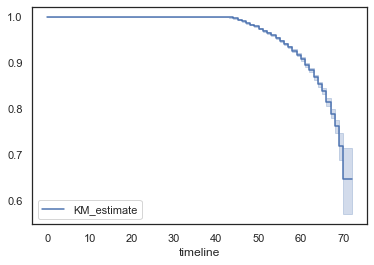

In [156]:
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()

The probability that the diabetes typeé  event has not occurred yet at age 40 is almost 0 , women older than 65 have 0.7 probability of being diagnosed with diabetes type 2 

<AxesSubplot:xlabel='timeline'>

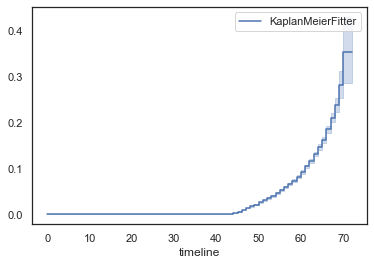

In [79]:
kmf.plot_cumulative_density()

<AxesSubplot:>

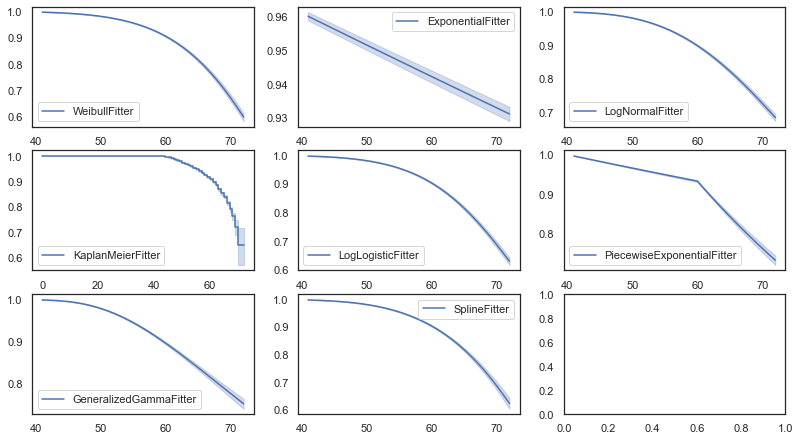

In [78]:
from lifelines import *
#### Different filters 
fig, axes = plt.subplots(3, 3, figsize=(13.5, 7.5))

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
sf = SplineFitter(np.percentile(T.loc[E.astype(bool)], [0, 50, 100])).fit(T, E, label='SplineFitter')

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
ggf.plot_survival_function(ax=axes[2][0])
sf.plot_survival_function(ax=axes[2][1])

In [80]:
cat_cols

['transitq4',
 'tabacq3',
 'statmeno_q3_cl',
 'allaitementoui',
 'ATCDfamdiabQ8',
 'encoupleq1',
 'gpsang_rhe',
 'grossesse',
 'hypertensionq3',
 'hypolipi2',
 'lateralite']

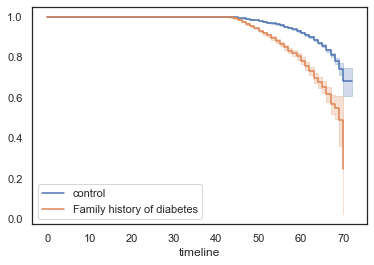

In [81]:
groups = data['ATCDfamdiabQ8']
ix = (groups == 1)

kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot_survival_function()

kmf.fit(T[ix], E[ix], label='Family history of diabetes')
ax = kmf.plot_survival_function(ax=ax)

Having diabetes type 2 history in the family increases the risk of diabetes type 2 with age

# Survival regression
While the above KaplanMeierFitter model is useful, it only gives us an “average” view of the population. Often we have specific data at the individual level that we would like to use. For this, we turn to survival regression.

In [164]:
from lifelines import CoxPHFitter

# Split train and test 
train,test= train_test_split(data_risk, test_size=0.20, random_state=42)
### Deal wit nan values
# Fill in nan values with median 
medians = train.mean()

train=train.fillna(medians)
# Apply it on Test 
test=test.fillna(medians)



# Fit the model
cph = CoxPHFitter()
cph.fit(train, 'T', event_col='E')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 58312 total observations, 55267 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 58312
number of events observed = 3045
   partial log-likelihood = -29117.46
         time fit was run = 2022-01-24 12:15:08 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
alcool           -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
kcalsac          -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
aphyq3           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ATCDfamdiabQ8     1.07       2.91       0.04             0.98             1.15                 2.67                 3.17
FDEP99            0.07       1.07       0.02             0.03             0.11                 1.03                 1.11
FRAP_I_NC        -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
hypolipi2         0.06       1.06       0.01             0.05             0.07                 1.05                 1.07
ttailleq4         0.04       1.04       0.00             0.04             0.04                 1.04                 1.04
pattern_western   0.37       1.44       0.02             0.32             0.42                 1.38                 1.52
pattern_prudent   0.23       1.26       0.02             0.19             0.26                 1.21                 1.30
PRAL              0.01       1.01       0.00             0.01             0.01                 1.01                 1.01

                    z      p   -log2(p)
covariate                              
alcool          -3.35 <0.005      10.27
kcalsac         -5.66 <0.005      25.95
aphyq3          -2.21   0.03       5.20
ATCDfamdiabQ8   24.39 <0.005     433.97
FDEP99           3.81 <0.005      12.82
FRAP_I_NC       -2.76   0.01       7.45
hypolipi2        9.54 <0.005      69.26
ttailleq4       24.74 <0.005     446.53
pattern_western 14.82 <0.005     162.61
pattern_prudent 12.20 <0.005     111.39
PRAL             9.82 <0.005      73.14
---
Concordance = 0.73
Partial AIC = 58256.93
log-likelihood ratio test = 2010.88 on 11 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:>

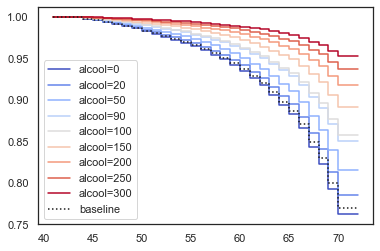

In [170]:
cph.plot_partial_effects_on_outcome(covariates='alcool', values=[0, 20, 50,90,100,150,200, 250,300], cmap='coolwarm')

In [168]:
data_risk.alcool.describe()

count    72890.000000
mean        11.636730
std         14.087916
min          0.000000
25%          1.600000
50%          6.870000
75%         16.570000
max        304.360000
Name: alcool, dtype: float64